# Spark-Redis-Recommender

In this notebook, we will walk through the development of a Movie Recommendaiton engine. We will use the ratings dataset from `MovieLens` to train an `ALS model` using `Apache Spark ML` package. We will store the model results in `Redis`, a fast in-memory key-value store and serve recommendations from there.


**In this notebook we will walk through**

- Loading the MovieLen dataset and performing some data exploration tasks
- Building/Training a Matrix Factorization (ALS) model on the user-ratings data using Apache Spark
- Storing the model outcomes in Redis
- Serving recommendations from Redis 

## Pre-requisists 

In order to run this notebook successfully you will need to

 - download and unzip the [MovieLens Dataset](https://grouplens.org/datasets/movielens/), and export ```DATASET_PATH``` as an environment variable (highlighted below).
   - Download the [small-dataset](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)
   - Download the [full-dataset](http://files.grouplens.org/datasets/movielens/ml-latest.zip)

 - create and use a python v.3.5 environment with the following packages installed:
   - numpy 
   - matplotlib 
   - redis
   
 - have a valid pyspark installation (either a cluster or locally)
   - this notebook is expected to run via something like 
   ```bash
   export PYSPARK_DRIVER_PYTHON="jupyter"
   export PYSPARK_DRIVER_PYTHON_OPTS="notebook"
   export DATASET_PATH=/path/to/dataset
   $SPARK_HOME/bin/pyspark
   ```
   
   which creates a SparkSession object under the hood and bind it to the notebook. Alternatively, SparkSession object can be initialized using: 
   ```python
   from pyspark.sql import SparkSession
   # programmatically create SparkSession
   spark = SparkSession.builder.getOrCreate()
   ```
   
   **note:** the python environment at the driver and executors shall be identical 
 - have a valid `redis` deployment
   - for example, you can use docker ```docker run -d -p 6379:6379 redis ```
    
 - create a valid TMDB APIKEY (to show movie posters while serving recommendations). More information on how to create a TMDB APIKEY can be found [here](https://developers.themoviedb.org/3)

## Using Redis

For the purpose of this demonstration, we are running a `single Redis instance` locally, and using `multiple=3 Redis Databases`. One for storing the `input: UserTopRatings`, one for storing the `input: MoviesInformation` and one for storing the model `output: UserTopRecommendations`. In a typical recommendaiton pipeline, you would store the latter only.

Using Multiple Databases running on a SINGLE instance, is deprecated because it is, in general, better to launch multiple Redis servers on the same machine rather than using multiple databases. Redis is single threaded. Thus, a single Redis server with multiple databases only uses one CPU core. On the other hand, if multiple Redis servers are used, it is possible to take advantage of multiple CPU cores. Multiple databases make administration of Redis harder and may complicate performance and resource usage diagnosis. It would not be easy to figure out which database is causing issues. Some Redis clients do not even support multiple Redis...

Note that we are writing the data to the single redis instance via the driver only. We are not using any spark connectors for redis. Typically you would use something like the one represented here: https://github.com/Anchormen/spark-redis-connector 

In [1]:
import redis
redis_host='localhost'
redis_port=6379

# redis client to manage writing to and reading from the REDIS database for input: UserTopRatings
ratings_dbid=0
redis_ratings = redis.StrictRedis(host=redis_host, port=redis_port, db=ratings_dbid)

# redis client to manage writing to and reading from the REDIS database for input: MoviesInformation
movies_dbid=1
redis_movies = redis.StrictRedis(host=redis_host, port=redis_port, db=movies_dbid)

# redis client to manage writing to and reading from the REDIS database for the model output: USerTopRecommendations
recommendations_dbid=2
redis_recommendations = redis.StrictRedis(host=redis_host, port=redis_port, db=recommendations_dbid)

### verify python version 

In [2]:
# verify python version
! python --version

Python 3.5.6 :: Anaconda, Inc.


### verify spark is running  

In [3]:
# verify spark is running 
spark

### verify dataset path
* This notebook uses the **small** version of the latest `MovieLens` movie rating dataset, containing around `9,000 movie`, `600 user` and `100,000` rating.

* The latest version of the data can be downloaded from https://grouplens.org/datasets/movielens/latest/
* Download the `ml-latest-small.zip` file and unzip it to a suitable location on your system

The folder should contain a number of CSV files. We will be using the following files:
* `ratings.csv` - movie rating data
* `links.csv` - external database ids for each movie
* `movies.csv` - movie title and genres

In [4]:
import os
dataset_path=os.environ['DATASET_PATH']
print('dataset_path: {}'.format(dataset_path))

dataset_files=os.listdir(dataset_path)
print('dataset_files: {}'.format(dataset_files))

dataset_path: /home/elsiouffy/Development/data/ml-latest-small
dataset_files: ['movies.csv', 'links.csv', 'ratings.csv', 'README.txt', 'tags.csv']


## Step 1: Loading The Data & Data Exploration 

### Load Ratings Data

The ratings data consists of around 100,000 ratings given by users to movies. Each row of the `DataFrame` consists of a `userId`, `movieId`, `timestamp` and `rating` given by the user to the movie.

In [5]:
# load ratings data
# drop timestamp column since its not used in building the model
ratings_df = spark \
    .read \
    .csv("{}/{}".format(dataset_path, "ratings.csv"), header=True, inferSchema=True) \
    .drop('timestamp') \
    .cache()

ratings_count=ratings_df.count()

print("ratings_count: {}".format(ratings_count))
ratings_df.show(5, truncate=False)
ratings_df.printSchema()

ratings_count: 100836
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|1     |1      |4.0   |
|1     |3      |4.0   |
|1     |6      |4.0   |
|1     |47     |5.0   |
|1     |50     |5.0   |
+------+-------+------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



### Ratings Data Exploration [Users]
In the following cells we show 
 - the number of users
 - the minimum number of ratings given by a user
 - the maximum number of ratings given by a user 
 - the average number of ratings given by a user 

In [6]:
from pyspark.sql.functions import col
n_users = ratings_df.select('userId').distinct().count()
min_user_rating_count = ratings_df.groupby('userId').count().sort(col('count').asc()).take(1)[0]['count']
max_user_rating_count = ratings_df.groupby('userId').count().sort(col('count').desc()).take(1)[0]['count']
avg_user_rating_count = ratings_df.groupby('userId').count().groupby().avg('count').take(1)[0]['avg(count)']

print("n_users: {}".format(n_users))
print('min_user_rating_count: {}'.format(min_user_rating_count))
print('max_user_rating_count: {}'.format(max_user_rating_count))
print('avg_user_rating_count: {}'.format(avg_user_rating_count))

n_users: 610
min_user_rating_count: 20
max_user_rating_count: 2698
avg_user_rating_count: 165.30491803278687


using a more efficient way (multiple aggregations)

In [7]:
import pyspark.sql.functions as F

ratings_df.groupby('userId').count() \
    .agg(
        F.count('count').alias('n_users'), 
        F.min('count').alias('min_user_rating_count'), 
        F.max('count').alias('max_user_rating_count'), 
        F.avg('count').alias('avg_user_rating_count')
        ) \
    .show()

+-------+---------------------+---------------------+---------------------+
|n_users|min_user_rating_count|max_user_rating_count|avg_user_rating_count|
+-------+---------------------+---------------------+---------------------+
|    610|                   20|                 2698|   165.30491803278687|
+-------+---------------------+---------------------+---------------------+



using built in describe function in Spark 

In [8]:
print("summary statistics user ratings counts")
ratings_df.groupBy("userId").count().select('count').describe().show()

summary statistics user ratings counts
+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|               610|
|   mean|165.30491803278687|
| stddev| 269.4805843871719|
|    min|                20|
|    max|              2698|
+-------+------------------+



### Ratings Data Exploration [Movies]
In the following cells we show 
 - the number of movies
 - the minimum number of ratings given to a movie
 - the maximum number of ratings given to a movie
 - the average number of ratings given to a movie

using built in `describe` function in Spark

In [9]:
print("summary statistics movies ratings counts")
ratings_df.groupBy("movieId").count().select('count').describe().show()

summary statistics movies ratings counts
+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|              9724|
|   mean|10.369806663924312|
| stddev| 22.40100480960961|
|    min|                 1|
|    max|               329|
+-------+------------------+



### Ratings Data Exploration [Ratings]
In the following cells we show/plot the distribution of ratings

In [10]:
from pyspark.sql.functions import asc
ratings_df.groupby('rating').count().sort(asc('rating')).show()

+------+-----+
|rating|count|
+------+-----+
|   0.5| 1370|
|   1.0| 2811|
|   1.5| 1791|
|   2.0| 7551|
|   2.5| 5550|
|   3.0|20047|
|   3.5|13136|
|   4.0|26818|
|   4.5| 8551|
|   5.0|13211|
+------+-----+



In [11]:
# creating a sorted list of ratings counts (to use in plots)
x = ratings_df.groupBy("rating").count().collect()

# sort in place based on ratings (i.e. from 0.5 -- 5)
x.sort(key=lambda x: x['rating'], reverse=False)
sorted_ratings_counts_list = list(map(lambda x: x['count'], x))
print("sorted_ratings_counts_list: {}".format(sorted_ratings_counts_list))

sorted_ratings_counts_list: [1370, 2811, 1791, 7551, 5550, 20047, 13136, 26818, 8551, 13211]


In [12]:
import numpy as np
import matplotlib.pyplot as plt

n_groups = 10
fig, ax = plt.subplots()
index = np.arange(n_groups)
x_labels=list(map(lambda x: str(x), list(np.arange(0.5,5.5,0.5))))
bar_width = 0.5
opacity = 0.4

rects1 = plt.bar(index, sorted_ratings_counts_list, bar_width, alpha=opacity, color='b', label='ratings')
plt.xlabel('ratings')
plt.ylabel('Counts')

plt.title('Distribution of ratings')

plt.xticks(index + bar_width, x_labels)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 640x480 with 1 Axes>

### Ratings Data Exploration [Other]


In [13]:
ratings_df.stat.crosstab("userId", "rating").show(5)
ratings_df.stat.crosstab("movieId", "rating").show(5)

+-------------+---+---+---+---+---+---+---+---+---+---+
|userId_rating|0.5|1.0|1.5|2.0|2.5|3.0|3.5|4.0|4.5|5.0|
+-------------+---+---+---+---+---+---+---+---+---+---+
|           69|  0|  0|  0|  2|  0|  3|  0| 17|  0| 24|
|          365| 12| 14| 28| 36| 41| 47| 49| 32| 10|  8|
|          138|  2|  0|  3|  0|  2|  2|  1|  1|  3|  8|
|          101|  0|  3|  0|  8|  0| 11|  0| 30|  0|  9|
|          479|  0| 15|  0| 30|  0| 51|  0| 52|  0| 33|
+-------------+---+---+---+---+---+---+---+---+---+---+
only showing top 5 rows

+--------------+---+---+---+---+---+---+---+---+---+---+
|movieId_rating|0.5|1.0|1.5|2.0|2.5|3.0|3.5|4.0|4.5|5.0|
+--------------+---+---+---+---+---+---+---+---+---+---+
|          2163|  0|  1|  0|  1|  2|  1|  0|  0|  0|  0|
|          8607|  0|  0|  0|  0|  0|  1|  1|  2|  0|  1|
|           645|  0|  0|  0|  0|  0|  1|  0|  1|  0|  0|
|         95105|  0|  0|  0|  1|  3|  0|  1|  2|  1|  1|
|           892|  0|  0|  0|  0|  0|  6|  2|  4|  0|  1|
+--------------

### Writing User Top Ratings To Redis
In the following cells we will write each users TOP ratings into Redis. This step is only performed for the purpose of this tutorial, as the users top ratings will be displayed later with recommendations, and is not required in a typical recommenaditon engine.


In [14]:
from pyspark.sql.functions import struct
user_ratings_df = ratings_df.select('userId', struct('movieId', 'rating').alias('movieAndRating'))
user_ratings_df.show(5, truncate=False)
user_ratings_df.printSchema()

+------+--------------+
|userId|movieAndRating|
+------+--------------+
|1     |[1, 4.0]      |
|1     |[3, 4.0]      |
|1     |[6, 4.0]      |
|1     |[47, 5.0]     |
|1     |[50, 5.0]     |
+------+--------------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieAndRating: struct (nullable = false)
 |    |-- movieId: integer (nullable = true)
 |    |-- rating: double (nullable = true)



In [15]:
from pyspark.sql.functions import collect_list

user_ratings_df = user_ratings_df \
    .groupby('userId') \
    .agg(collect_list('movieAndRating').alias('userRatings'))

user_ratings_df.show(5)
user_ratings_df.printSchema()

+------+--------------------+
|userId|         userRatings|
+------+--------------------+
|   148|[[356, 4.0], [119...|
|   463|[[110, 4.5], [296...|
|   471|[[1, 5.0], [296, ...|
|   496|[[720, 1.0], [858...|
|   243|[[10, 5.0], [36, ...|
+------+--------------------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- userRatings: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: double (nullable = true)



In [16]:
from pyspark.sql.functions import udf

user_ratings_schema = user_ratings_df.select('userRatings').schema.fields[0].dataType
print("user_ratings_schema: {}".format(user_ratings_schema))

def sort_and_limit(lst, n=5, desc=True):
    return sorted(lst, key=lambda x: x[1], reverse=desc)[0:n]
sort_and_limit_udf = udf(sort_and_limit, user_ratings_schema)

l=[[1,2],[3,4],[3,2],[0,1], [13,2],[10,1],[1,10],[3,3]]
sort_and_limit(l)

user_ratings_schema: ArrayType(StructType(List(StructField(movieId,IntegerType,true),StructField(rating,DoubleType,true))),true)


[[1, 10], [3, 4], [3, 3], [1, 2], [3, 2]]

In [17]:
user_ratings_df = user_ratings_df.select('userId', sort_and_limit_udf('userRatings').alias('userRatings'))

user_ratings_df.show(5, truncate=False)
user_ratings_df.printSchema()

+------+----------------------------------------------------------------------+
|userId|userRatings                                                           |
+------+----------------------------------------------------------------------+
|148   |[[30816, 5.0], [40629, 5.0], [98491, 5.0], [60069, 4.5], [81847, 4.5]]|
|463   |[[5952, 5.0], [7153, 5.0], [110, 4.5], [1221, 4.5], [1552, 4.5]]      |
|471   |[[1, 5.0], [2324, 5.0], [79702, 5.0], [527, 4.5], [60069, 4.5]]       |
|496   |[[858, 5.0], [904, 5.0], [912, 4.5], [58559, 4.5], [106920, 4.5]]     |
|243   |[[10, 5.0], [62, 5.0], [112, 5.0], [161, 5.0], [165, 5.0]]            |
+------+----------------------------------------------------------------------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- userRatings: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: double (nullable = true)



In [18]:
def write_user_ratings_to_redis (redis_client, user_ratings_df, ratings_col='userRatings'):
    
    """
    writes movies ratings for each user into redis sorted set
    i.e. will be sorted by rating in redis
    
    user_ratings_df: Row(userId=>Int: userRatings=>List[Row(moveidId, rating)]) 
    """

    # writes to redis sorted set Key=userId, value=List[movieId] sorted by rating
    for row in user_ratings_df.collect():
        uid = row['userId']
        ratings_list = row[ratings_col]
        ratings_dict = dict()
        
        # ratings_dict: {movieId1: rating1, movieId2: rating2, ...etc.}
        for rating in ratings_list:
            key = str(rating['movieId'])
            vlu = rating['rating']
            ratings_dict[key]=vlu

        redis_client.delete(uid)
        redis_client.zadd(uid, **ratings_dict)

In [19]:
print('writing input user ratings to redis sorted set')
write_user_ratings_to_redis(redis_ratings, user_ratings_df)
print('DONE!')

writing input user ratings to redis sorted set
DONE!


In [20]:
uid=240
n_top=5
redis_ratings.zrange(uid, 0, n_top-1, desc=True, withscores=True)

[(b'39', 5.0), (b'34', 5.0), (b'2', 5.0), (b'19', 5.0), (b'1', 5.0)]

### Load Movies Data

The file `movies.csv` contains the `movieId`, `title` and `genres` for each movie. As you can see, the `genres` field is a bit tricky to use, as the genres are in the form of one string delimited by the `|` character: `Adventure|Animation|Children|Comedy|Fantasy`. Additionally the movie `title` string contains the `release year`, which is a separate field we can extract.

In [21]:
# load raw data from CSV
movies_df = spark.read.csv(dataset_path + "/movies.csv", header=True, inferSchema=True)
movies_df.show(5, truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



### Movies Data Transformation 1

Create a user-defined function (UDF) to extract this delimited string into a list of genres

In [22]:
from pyspark.sql.types import ArrayType, StringType
# define a UDF to convert the raw genres string to an array of genres and lowercase
def extract_genres(genres):
    return genres.lower().split("|")
extract_genres_udf = udf(extract_genres , ArrayType(StringType()))
extract_genres("Adventure|Animation|Children|Comedy|Fantasy")

['adventure', 'animation', 'children', 'comedy', 'fantasy']

Create a UDF to extract the release year from the title using a Python regular expression.

In [23]:
from pyspark.sql.types import StructType, StructField
import re

# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        return (title, 1970)

extract_year_udf = udf(extract_year,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    

extract_year("MovieExample (2010)")

('MovieExample', '2010')

APPLY!

In [24]:
movies_df = movies_df \
    .select("movieId", 
            extract_year_udf("title").title.alias("title"), 
            extract_year_udf("title").release_date.alias("release_date"),
            extract_genres_udf("genres").alias("genres"))

n_movies = movies_df.count()
print("n_movies: {}".format(n_movies))
movies_df.show(5, truncate=False)

n_movies: 9742
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



### Movies Data Transformation 2

Next, we join the `links.csv` data to `movies` so that there is an id for _The Movie Database_ corresponding to each movie. We will use this id to retrieve movie poster images when displaying recommendations later.

In [25]:
link_data = spark.read.csv(dataset_path + "/links.csv", header=True, inferSchema=True)
link_data.show(5)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
+-------+------+------+
only showing top 5 rows



In [26]:
# join movies with links to get TMDB id
movies_df = movies_df.join(link_data, on='movieId')\
    .select(movies_df.columns + ['tmdbId'])

n_movies = movies_df.count()
print("n_movies: {}".format(n_movies))
movies_df.show(5, truncate=False)

n_movies: 9742
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+-------------------------------------------------+------+
only showing 

### Write Transformed Movies Data into Redis

Writing movie information into redis. In Redis, each movie is represented by a key/value pair. In a giant HashMap. The `key` for each movie is the `movieId`, and the `value` itself is a `Mapping`, from field in the DataFrame to a key in the mapping

In [27]:
movies_map_df = movies_df.select('movieId', struct(movies_df.columns).alias('movieInfo'))
movies_map_df.show(5, truncate=False)
movies_map_df.printSchema()

+-------+----------------------------------------------------------------------------+
|movieId|movieInfo                                                                   |
+-------+----------------------------------------------------------------------------+
|1      |[1, Toy Story, 1995, [adventure, animation, children, comedy, fantasy], 862]|
|2      |[2, Jumanji, 1995, [adventure, children, fantasy], 8844]                    |
|3      |[3, Grumpier Old Men, 1995, [comedy, romance], 15602]                       |
|4      |[4, Waiting to Exhale, 1995, [comedy, drama, romance], 31357]               |
|5      |[5, Father of the Bride Part II, 1995, [comedy], 11862]                     |
+-------+----------------------------------------------------------------------------+
only showing top 5 rows

root
 |-- movieId: integer (nullable = true)
 |-- movieInfo: struct (nullable = false)
 |    |-- movieId: integer (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- release_

In [28]:
# writing movies data to Redis
movies_list=movies_map_df.collect()
for movie in movies_list:
    k=movie['movieId']
    v=movie['movieInfo'].asDict()
    redis_movies.hmset(k,v)

In [29]:
# Quering a movie from redis
movie_id=10
print(redis_movies.hgetall(movie_id))
print()
print(redis_movies.hget(movie_id, 'title').decode())
print(redis_movies.hget(movie_id, 'tmdbId').decode())

{b'movieId': b'10', b'tmdbId': b'710', b'title': b'GoldenEye', b'release_date': b'1995', b'genres': b"['action', 'adventure', 'thriller']"}

GoldenEye
710


### Summary 

From the previous steps we now have
 - ratings_df: spark dataframe that will be used in training the ALS Matrix Factorization Model 
 - redis_ratings: redis_client connected to a redis database containing top ratings given by each user
 - redis_movies: redis_client connect to a redis database containing movie information

In [30]:
print("Ratings DataFrame")
ratings_df.show(5, truncate=False)
print()
print("Query Redis Movies for Movie details about movieId: {}".format(movie_id))
print(redis_movies.hgetall(movie_id))
print()
print("Query Redis Ratings for top User ratings for userId: {}".format(uid))
print(redis_ratings.zrange(uid, 0, n_top-1, desc=True, withscores=True))

Ratings DataFrame
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|1     |1      |4.0   |
|1     |3      |4.0   |
|1     |6      |4.0   |
|1     |47     |5.0   |
|1     |50     |5.0   |
+------+-------+------+
only showing top 5 rows


Query Redis Movies for Movie details about movieId: 10
{b'movieId': b'10', b'tmdbId': b'710', b'title': b'GoldenEye', b'release_date': b'1995', b'genres': b"['action', 'adventure', 'thriller']"}

Query Redis Ratings for top User ratings for userId: 240
[(b'39', 5.0), (b'34', 5.0), (b'2', 5.0), (b'19', 5.0), (b'1', 5.0)]


## Step 2: Train a recommmender model on the ratings data

In the following blocks we will use the ratings data to build a collaborative filtering recommendation model using Apache Spark's implementation of ALS. 

[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) is a recommendation approach that is effectively based on the "wisdom of the crowd". It makes the assumption that, if two people share similar preferences, then the things that one of them prefers could be good recommendations to make to the other. In other words, if user A tends to like certain movies, and user B shares some of these preferences with user A, then the movies that user A likes, that user B _has not yet seen_, may well be movies that user B will also like.

In a similar manner, we can think about _items_ as being similar if they tend to be rated highly by the same people, on average. 

Hence these models are based on the combined, collaborative preferences and behavior of all users in aggregate. They tend to be very effective in practice (provided you have enough preference data to train the model). The ratings data we have is a form of _explicit preference data_, perfect for training collaborative filtering models.


### Alternating Least Squares
Alternating Least Squares (ALS) is a specific algorithm for solving a type of collaborative filtering model known as [matrix factorization (MF)](https://en.wikipedia.org/wiki/Matrix_decomposition). The core idea of MF is to represent the ratings as a _user-item ratings matrix_. In the diagram below you will see this matrix on the left (with users as _rows_ and movies as _columns_). The entries in this matrix are the ratings given by users to movies.

You may also notice that the matrix has _missing entries_ because not all users have rated all movies. In this situation we refer to the data as _sparse_.

![als-diagram.png](als-diagram.png)

MF methods aim to find two much smaller matrices (one representing the _users_ and the other the _items_) that, when multiplied together, re-construct the original ratings matrix as closely as possible. This is know as _factorizing_ the original matrix, hence the name of the technique.

The two smaller matrices are called _factor matrices_ (or _latent features_). The user and movie factor matrices are illustrated on the right in the diagram above. The idea is that each user factor vector is a compressed representation of the user's preferences and behavior. Likewise, each item factor vector is a compressed representation of the item. Once the model is trained, the factor vectors can be used to make recommendations, which is what you will do in the following sections.

__Further reading:__
* [Spark MLlib Collaborative Filtering](http://spark.apache.org/docs/latest/ml-collaborative-filtering.html)
* [Alternating Least Squares and collaborative filtering](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/)
* [Quora question on Alternating Least Squares](https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems-And-why-does-this-algorithm-work-intuition-behind-this)

Fortunately, Spark's MLlib machine learning library has a scalable, efficient implementation of matrix factorization built in, which we can use to train our recommendation model.

**Spark's ALS takes the following inputs:**
 - numBlocks: the number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10)
 - rank: the number of latent factors in the model (defaults to 10)
 - maxIter: the maximum number of iterations to run (defaults to 10)
 - regParam: the regularization parameter in ALS - used to prevent overfitting (defaults to 0.1)
 - implicitPrefs: specifies whether to use the explicit feedback ALS variant or the one adapted for implicit feedback data (defaults to false, which means it's using explicit feedback)
   - alpha: This is a parameter applicable to the implicit feedback variant of ALS, which governs the baseline confidence in preference observations (defaults to 1.0)
 - nonnegative: This parameter specifies whether or not to use non-negative constraints for least squares (defaults to false)

In [31]:
training_df,test_df = ratings_df.randomSplit([0.8, 0.2])

In [32]:
from pyspark.ml.recommendation import ALS

rank = 20  # number of latent factors
maxIter = 10
regParam=0.01  # prevent overfitting

als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", 
          regParam=regParam, 
          rank=rank, 
          maxIter=maxIter,
          coldStartStrategy="drop",
          seed=12)

model = als.fit(training_df)

In [33]:
test_df.show(5, truncate=False)
predictions_df = model.transform(test_df)
predictions_df.show(5, truncate=False)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|1     |6      |4.0   |
|1     |163    |5.0   |
|1     |231    |5.0   |
|1     |235    |4.0   |
|1     |356    |4.0   |
+------+-------+------+
only showing top 5 rows

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|133   |471    |4.0   |4.54487   |
|218   |471    |4.0   |3.030225  |
|462   |471    |2.5   |1.273783  |
|387   |471    |3.0   |2.7084527 |
|520   |471    |5.0   |3.0389757 |
+------+-------+------+----------+
only showing top 5 rows



In [34]:
# in case we are not using coldStartStrategy="drop"

total_predictions_count = predictions_df.count()
print('the number of TOTAL predictions is: {}'.format(total_predictions_count))

predictions_df = predictions_df.dropna()

valid_predictions_count = predictions_df.count()
print('the number of VALID predictions is: {}'.format(valid_predictions_count))

the number of TOTAL predictions is: 19305
the number of VALID predictions is: 19305


**Model Evaluation**

In [35]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
error = evaluator.evaluate(predictions_df)

error

1.2419963442003508

### ML Tuning: model selection and hyperparameter tuning

An important task in ML is `model selection`, or using data to find the best model or parameters for a given task. This is also called tuning. Tuning may be done for individual Estimators such as LogisticRegression, or for entire Pipelines which include multiple algorithms, featurization, and other steps. Users can tune an entire Pipeline at once, rather than tuning each element in the Pipeline separately.

MLlib supports model selection using tools such as `CrossValidator` and `TrainValidationSplit`. From which we are using the `CrossValidator`. These tools require the following items:
 - Estimator: algorithm or Pipeline to tune
 - Set of ParamMaps: parameters to choose from, sometimes called a “parameter grid” to search over
 - Evaluator: metric to measure how well a fitted Model does on held-out test data

At a high level, these model selection tools work as follows:
 - They split the input data into separate training and test datasets.
 - For each (training, test) pair, they iterate through the set of ParamMaps:
   - For each ParamMap, they fit the Estimator using those parameters, get the fitted Model, and evaluate the Model’s performance using the Evaluator.
 - They select the Model produced by the best-performing set of parameters.
 
The Evaluator can be a RegressionEvaluator for regression problems, a BinaryClassificationEvaluator for binary data, or a MulticlassClassificationEvaluator for multiclass problems. The default metric used to choose the best ParamMap can be overridden by the setMetricName method in each of these evaluators.

To help construct the parameter grid, we are using the ParamGridBuilder utility.

In [36]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop")

# creating parameter grid (parameters to be tuned)
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 15, 20],) \
    .addGrid(als.maxIter, [10, 15],) \
    .addGrid(als.regParam, [0.01, 0.1, 0.2, 0.3],) \
    .build()

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating")
crossval = CrossValidator(estimator=als, 
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(training_df)
best_model=cv_model.bestModel

In [37]:
best_rank=best_model.rank
best_regParm=best_model._java_obj.parent().getRegParam()
best_iterations=best_model._java_obj.parent().getMaxIter()

print("best_rank: {}".format(best_rank))
print("best_regParm: {}".format(best_regParm))
print("best_iterations: {}".format(best_iterations))

best_rank: 10
best_regParm: 0.2
best_iterations: 10


In [38]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

predictions_df = best_model.transform(test_df)
predictions_df.show(5, truncate=False)


error = evaluator.evaluate(predictions_df)
error

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|133   |471    |4.0   |2.6533482 |
|218   |471    |4.0   |2.90127   |
|462   |471    |2.5   |2.543425  |
|387   |471    |3.0   |2.9286814 |
|520   |471    |5.0   |3.3560743 |
+------+-------+------+----------+
only showing top 5 rows



0.8855058733012662

### Using the Model
- userFactors
- itemFactors
- recommendForAllUsers
- recommendForAllItems
- recommendForUserSubset
- recommendForItemSubset

In [39]:
best_model.userFactors.show(5)
best_model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.80464363, -0....|
| 20|[0.03559533, -0.2...|
| 30|[-0.122175545, -0...|
| 40|[-0.09842649, -0....|
| 50|[0.5106192, -0.01...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.2636927, -0.1...|
| 20|[0.20660873, -0.2...|
| 30|[1.5751286, -0.26...|
| 40|[0.24460384, -0.0...|
| 50|[0.29823792, -0.2...|
+---+--------------------+
only showing top 5 rows



## Step 3: Persisting the model [REDIS]



### Writing User Recommendations To Redis
* generate recommendations from our model
* write users receommendations to Redis

In [40]:
n_recs=5
users_recommendations_df = best_model.recommendForAllUsers(n_recs)

users_recommendations_df.show(5, truncate=False)
users_recommendations_df.printSchema()

print('writing model output user recommendations to redis sorted set')
write_user_ratings_to_redis (redis_recommendations, users_recommendations_df, ratings_col='recommendations')
print("DONE!")

+------+-------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                  |
+------+-------------------------------------------------------------------------------------------------+
|471   |[[3379, 4.9073014], [141718, 4.807711], [7815, 4.690309], [33649, 4.6704736], [7842, 4.65527]]   |
|463   |[[141718, 5.231237], [3379, 5.1741843], [59018, 5.1065636], [60943, 5.1065636], [7842, 5.097358]]|
|496   |[[3379, 4.8458376], [40491, 4.673306], [6818, 4.6711445], [5915, 4.636673], [5490, 4.636673]]    |
|148   |[[141718, 4.8015585], [3379, 4.742105], [33649, 4.735005], [67618, 4.71983], [6818, 4.5980334]]  |
|540   |[[141718, 5.65111], [3379, 5.64269], [7842, 5.5599465], [60943, 5.5523777], [59018, 5.5523777]]  |
+------+-------------------------------------------------------------------------------------------------+
only showing top 5 rows

root
 |-- us

In [41]:
uid=240
n_top=5
redis_recommendations.zrange(uid, 0, n_top-1, desc=True, withscores=True)

[(b'141718', 6.010890960693359),
 (b'67618', 5.8255696296691895),
 (b'33649', 5.642768859863281),
 (b'3086', 5.489073276519775),
 (b'3379', 5.447299957275391)]

## Step 4: Serving Recommendations From Redis
* Given a user, find the movies with the highest predicted rating
* Display the results as an HTML table in Jupyter

In [42]:
# [(movieId, rating)]

def get_user_ratings_from_redis(redis_client, uid, n_ratings=5):
    user_ratings = redis_client.zrange(uid, 0, n_ratings-1, desc=True, withscores=True)
    return list(map(lambda x: (int(x[0].decode()), float(x[1])), user_ratings))

uid=240
print("user: {} top ratings: {}".format(uid, get_user_ratings_from_redis(redis_ratings, uid)))
print("user: {} top recommendations {}".format(uid, get_user_ratings_from_redis(redis_recommendations, uid)))

user: 240 top ratings: [(39, 5.0), (34, 5.0), (2, 5.0), (19, 5.0), (1, 5.0)]
user: 240 top recommendations [(141718, 6.010890960693359), (67618, 5.8255696296691895), (33649, 5.642768859863281), (3086, 5.489073276519775), (3379, 5.447299957275391)]


In [43]:
def construct_movie_details(movie_id, rating=None):
    """
        given a movie id, retrieves relevant movie information from redis
        returns a dict containing movieId, tmdbId, title
    """
    res = dict()
    movie_info = redis_movies.hgetall(movie_id)
    # 
    res['movieId']=movie_id
    res['tmdbId']=int(movie_info[b'tmdbId'].decode())
    res['title']=movie_info[b'title'].decode()
        
    if rating:
        res['rating']=rating
    return res

print(construct_movie_details(1, 3.5))

{'movieId': 1, 'tmdbId': 862, 'title': 'Toy Story', 'rating': 3.5}


In [44]:
def get_user_ratings(redis_client, uid, n_ratings=5):
    user_ratings = get_user_ratings_from_redis(redis_client, uid, n_ratings)  # [(movieId, rating)
    
    # List [Dict (movieId, tmdbId, title, rating)]
    return list(map(lambda x: construct_movie_details(x[0], x[1]), user_ratings))
    #return user_ratings


print(get_user_ratings(redis_ratings, 240))
print()
print(get_user_ratings(redis_recommendations, 240))

[{'movieId': 39, 'tmdbId': 9603, 'title': 'Clueless', 'rating': 5.0}, {'movieId': 34, 'tmdbId': 9598, 'title': 'Babe', 'rating': 5.0}, {'movieId': 2, 'tmdbId': 8844, 'title': 'Jumanji', 'rating': 5.0}, {'movieId': 19, 'tmdbId': 9273, 'title': 'Ace Ventura: When Nature Calls', 'rating': 5.0}, {'movieId': 1, 'tmdbId': 862, 'title': 'Toy Story', 'rating': 5.0}]

[{'movieId': 141718, 'tmdbId': 323373, 'title': 'Deathgasm', 'rating': 6.010890960693359}, {'movieId': 67618, 'tmdbId': 13808, 'title': 'Strictly Sexual', 'rating': 5.8255696296691895}, {'movieId': 33649, 'tmdbId': 19316, 'title': 'Saving Face', 'rating': 5.642768859863281}, {'movieId': 3086, 'tmdbId': 25898, 'title': 'Babes in Toyland', 'rating': 5.489073276519775}, {'movieId': 3379, 'tmdbId': 35412, 'title': 'On the Beach', 'rating': 5.447299957275391}]


**Fetching movie posters from TMdb API**

movie title: Jumanji
movie_poster_url: https://image.tmdb.org/t/p/w500/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg


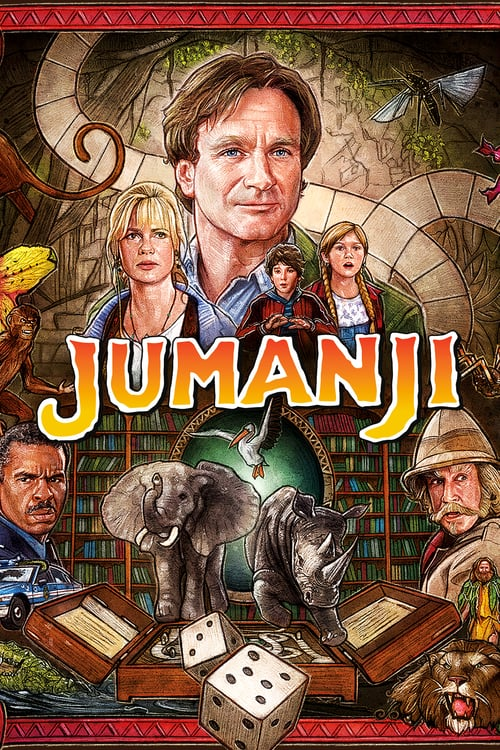

In [45]:
from IPython.display import Image, HTML, display
import tmdbsimple as tmdb
from tmdbsimple import APIKeyError
# TMdb API key
tmdb.API_KEY = '4b577aa255b7f9215deb1ed3933b0d7c'

def get_poster_url(tmdbid):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'  # base URL for TMDB poster images
    try:
        try:
            movie = tmdb.Movies(tmdbid).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"

movie_id=2
movie_info=construct_movie_details(movie_id)

try:
    print("movie title: {}".format(movie_info['title']))
    movie_poster_url =  get_poster_url(movie_info['tmdbId'])
    print("movie_poster_url: {}".format(movie_poster_url))
    display(Image(movie_poster_url, width=200))
except Exception as e:
    print(e)
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

In [46]:
def display_user_recs(uid):
    # utility function that constructs an HTML of ratings
    # ---------------------------------------------------
    def construct_recommendations_html(ratings):
        html = "<table border=0>"
        i = 0
        for movie in ratings:
            movie_im_url = get_poster_url(movie['tmdbId'])
            movie_title = movie['title']
            movie_rating = movie['rating']
            #
            html += "<td><h5>{}</h5><img src={} width=150></img></td><td><h5>{:.2f}</h5></td>".format(movie_title, movie_im_url, movie_rating)

            i += 1
            if i % 5 == 0:
                html += "</tr><tr>"
        html += "</tr></table>"
        return html
    
    
    # display the movies that this user has rated highly 
    # -------------------------------------------------
    top_rated = get_user_ratings(redis_ratings, uid)  # List [Dict (movieId, tmdbId, rating, title)]
    display(HTML("<h2>Top Ratings By User: {}</h2>".format(uid)))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    top_rated_html = construct_recommendations_html(top_rated)
    display(HTML(top_rated_html))
    
    
    # display the movies that this user has the highest score
    # -------------------------------------------------    
    recommendations = get_user_ratings(redis_recommendations, uid)
    display(HTML("<br/>"))
    display(HTML("<h2>Top Recommendations For User: {}</h2>".format(uid)))
    display(HTML("<h4>The user is recommended these movies:</h4>"))
    recommendations_html = construct_recommendations_html(recommendations)
    display(HTML(recommendations_html))

### Serving Recommendations

Now, we're ready to generate movie recommendations, personalized for specific users.
Given a user, we can recommend movies to that user based on the predicted ratings from our model. Recall that the collaborative filtering model means that, at a high level, we will recommend movies _liked by other users who liked the same movies as the given user_.

In [47]:
display_user_recs(12)

Note that since we are using a very small dataset, the results may not be too good.